In [123]:
# === 1. Imports e leitura de dados ===
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score


In [124]:
# === 2. Carregamento e pré-processamento ===
dataset = pd.read_csv('Matches.csv')
features = [
    'HomeElo', 'AwayElo',
    'Form3Home', 'Form3Home',
    'Form5Away', 'Form5Away',
    'OddHome', 'OddDraw', 'OddAway',
    'HandiSize',
    # 'HTHome', 'HTAway',
    ]
df = dataset[features + ['FTResult']].dropna().reset_index(drop=True)
X = StandardScaler().fit_transform(df[features])
y = LabelEncoder().fit_transform(df['FTResult'])


<ipython-input-124-75edf81ff16f>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('Matches.csv')


In [127]:
# === 3. Divisão dos dados e conversão para Tensor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)
y_train, y_test = torch.tensor(y_train, dtype=torch.long).to(device), torch.tensor(y_test, dtype=torch.long).to(device)

In [128]:
# Rebalanceamento das classes com peso
unique, counts = np.unique(y_train.cpu().numpy(), return_counts=True)
print(dict(zip(unique, counts)))
class_counts = np.bincount(y_train.cpu().numpy())
weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32).to(device)


{np.int64(0): np.int64(24757), np.int64(1): np.int64(23681), np.int64(2): np.int64(39388)}


In [129]:
# === 4. Modelo ===
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes=[], output_size=3):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_features, h))
            layers.append(nn.ReLU())
            in_features = h
        layers.append(nn.Linear(in_features, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [142]:
# === 5. Função de treinamento ===
def train(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.01, momentum=0):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.CrossEntropyLoss(weight=weights)
    # loss_fn = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train)
        loss = loss_fn(preds, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = model(X_test)
            val_loss = loss_fn(val_preds, y_test)
            val_acc = accuracy_score(y_test.cpu(), torch.argmax(val_preds, dim=1).cpu())

        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['val_acc'].append(val_acc)

        if epoch % 100 == 0:
            print(f"Epoch {epoch} - Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | Val Acc: {val_acc:.4f}")

    return history


In [143]:
# === 6. Avaliação ===
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X_test), dim=1)
    acc = accuracy_score(y_test.cpu(), preds.cpu())
    cm = confusion_matrix(y_test.cpu(), preds.cpu())
    print(f"Acurácia: {acc * 100:.2f}%")
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel("Predito"); plt.ylabel("Real")
    plt.title("Matriz de Confusão")
    plt.show()



== Arquitetura 1: [] ==
Epoch 0 - Loss: 1.2001 | Val Loss: 1.1597 | Val Acc: 0.3561
Epoch 100 - Loss: 0.9984 | Val Loss: 1.0006 | Val Acc: 0.5064
Epoch 200 - Loss: 0.9978 | Val Loss: 1.0002 | Val Acc: 0.5057
Epoch 300 - Loss: 0.9975 | Val Loss: 0.9999 | Val Acc: 0.5059
Epoch 400 - Loss: 0.9973 | Val Loss: 0.9998 | Val Acc: 0.5059
Acurácia: 50.64%


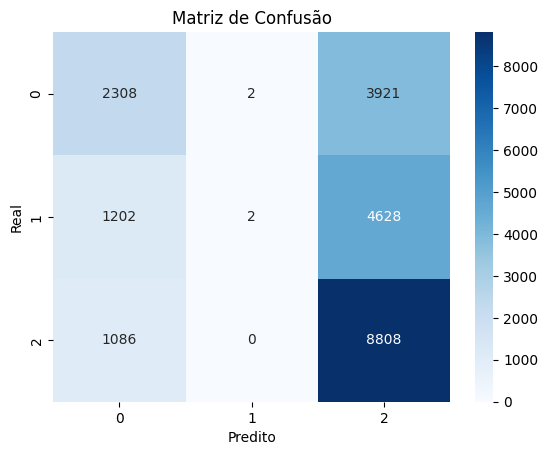


== Arquitetura 2: [10] ==
Epoch 0 - Loss: 1.0986 | Val Loss: 1.0926 | Val Acc: 0.4164
Epoch 100 - Loss: 1.0070 | Val Loss: 1.0076 | Val Acc: 0.4994
Epoch 200 - Loss: 1.0005 | Val Loss: 1.0021 | Val Acc: 0.5054
Epoch 300 - Loss: 0.9988 | Val Loss: 1.0008 | Val Acc: 0.5061
Epoch 400 - Loss: 0.9980 | Val Loss: 1.0001 | Val Acc: 0.5068
Acurácia: 50.79%


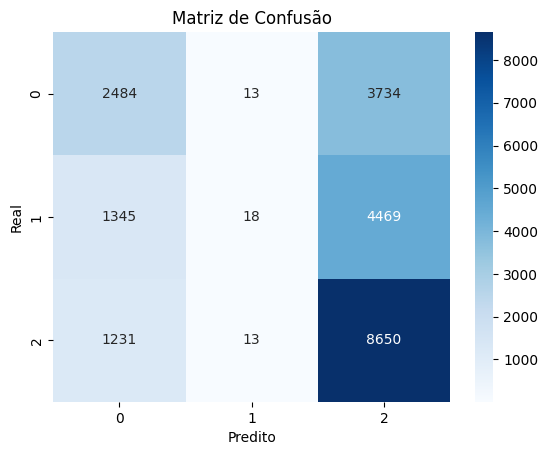


== Arquitetura 3: [20, 10] ==
Epoch 0 - Loss: 1.1420 | Val Loss: 1.1332 | Val Acc: 0.2858
Epoch 100 - Loss: 1.0169 | Val Loss: 1.0166 | Val Acc: 0.4949
Epoch 200 - Loss: 1.0011 | Val Loss: 1.0031 | Val Acc: 0.5033
Epoch 300 - Loss: 0.9985 | Val Loss: 1.0013 | Val Acc: 0.5032
Epoch 400 - Loss: 0.9978 | Val Loss: 1.0006 | Val Acc: 0.5044
Acurácia: 50.47%


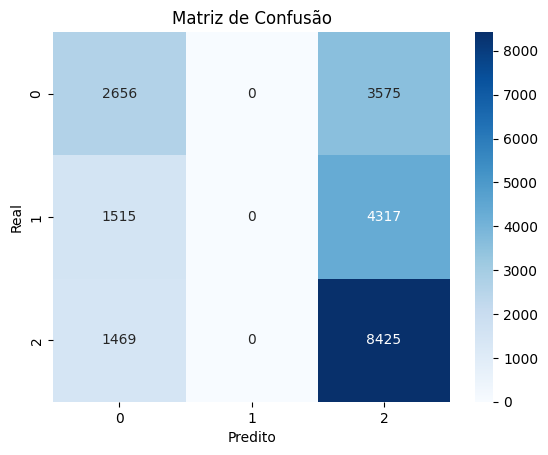


== Arquitetura 4: [40, 20, 10] ==
Epoch 0 - Loss: 1.1251 | Val Loss: 1.1210 | Val Acc: 0.2656
Epoch 100 - Loss: 1.0408 | Val Loss: 1.0411 | Val Acc: 0.4842
Epoch 200 - Loss: 1.0110 | Val Loss: 1.0128 | Val Acc: 0.4977
Epoch 300 - Loss: 0.9996 | Val Loss: 1.0021 | Val Acc: 0.5050
Epoch 400 - Loss: 0.9979 | Val Loss: 1.0005 | Val Acc: 0.5065
Acurácia: 50.73%


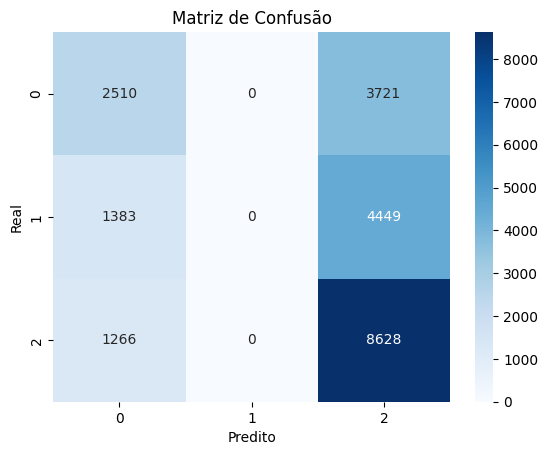


== Arquitetura 5: [80, 40, 20, 10] ==
Epoch 0 - Loss: 1.0733 | Val Loss: 1.0715 | Val Acc: 0.4506
Epoch 100 - Loss: 1.0315 | Val Loss: 1.0303 | Val Acc: 0.4509
Epoch 200 - Loss: 1.0086 | Val Loss: 1.0089 | Val Acc: 0.5046
Epoch 300 - Loss: 0.9986 | Val Loss: 1.0004 | Val Acc: 0.5055
Epoch 400 - Loss: 0.9972 | Val Loss: 0.9996 | Val Acc: 0.5065
Acurácia: 50.73%


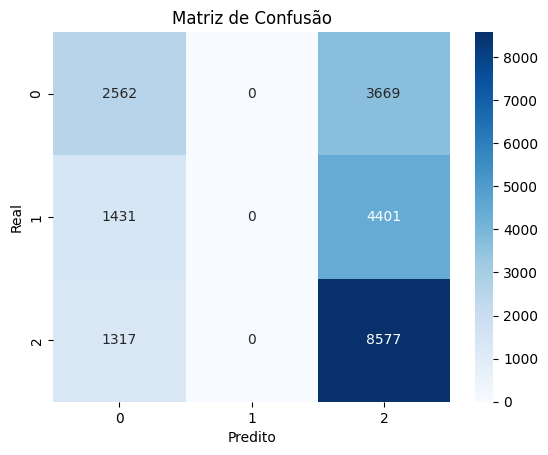

In [148]:
# === 7. Treinamento com diferentes arquiteturas ===
architectures = [
    [],
    [10],
    [20, 10],
    [40, 20, 10],
    [80, 40, 20, 10]
]

histories = []
accuracies = []

for i, arch in enumerate(architectures):
    print(f"\n== Arquitetura {i+1}: {arch} ==")
    model = MLP(input_size=X_train.shape[1], hidden_sizes=arch).to(device)
    history = train(model, X_train, y_train, X_test, y_test, epochs=500, lr=0.1)
    evaluate(model, X_test, y_test)
    histories.append((f"Arch {i+1}: {arch}", history))
    accuracies.append(history['val_acc'][-1])


In [149]:
# 📌 Identifique a melhor arquitetura:
best_idx = np.argmax(accuracies)
print(f"\nMelhor arquitetura sem momentum: {architectures[best_idx]} (Acurácia: {accuracies[best_idx]*100:.2f}%)")



Melhor arquitetura sem momentum: [10] (Acurácia: 50.79%)



== Repetindo melhor arquitetura COM momentum ==
Epoch 0 - Loss: 1.1240 | Val Loss: 1.1150 | Val Acc: 0.3282
Epoch 100 - Loss: 0.9964 | Val Loss: 0.9991 | Val Acc: 0.5079
Epoch 200 - Loss: 0.9957 | Val Loss: 0.9986 | Val Acc: 0.5063
Epoch 300 - Loss: 0.9952 | Val Loss: 0.9982 | Val Acc: 0.5055
Epoch 400 - Loss: 0.9949 | Val Loss: 0.9979 | Val Acc: 0.5060
Acurácia: 50.60%


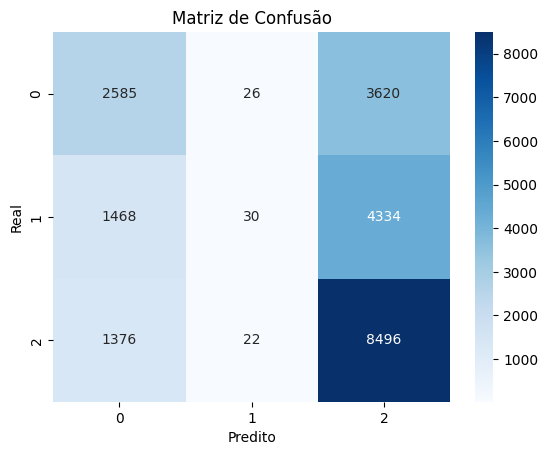

In [150]:
# 🔁 Treine novamente a melhor arquitetura com momentum:
print("\n== Repetindo melhor arquitetura COM momentum ==")
best_arch = architectures[best_idx]
model_momentum = MLP(input_size=X_train.shape[1], hidden_sizes=best_arch).to(device)
history_momentum = train(model_momentum, X_train, y_train, X_test, y_test, epochs=500, lr=0.1, momentum=0.9)
evaluate(model_momentum, X_test, y_test)


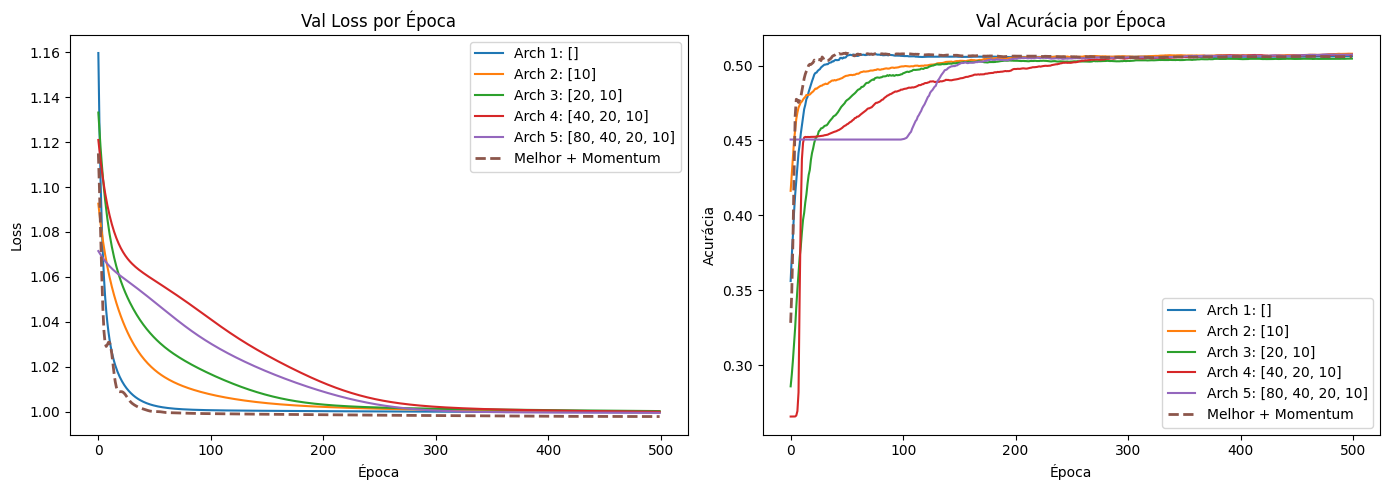

In [151]:
# 📈 Plote os gráficos:
def plot_metrics(histories, history_momentum=None):
    plt.figure(figsize=(14, 5))

    # Perda
    plt.subplot(1, 2, 1)
    for name, hist in histories:
        plt.plot(hist['val_loss'], label=name)
    if history_momentum:
        plt.plot(history_momentum['val_loss'], label='Melhor + Momentum', linestyle='--', linewidth=2)
    plt.title("Val Loss por Época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()

    # Acurácia
    plt.subplot(1, 2, 2)
    for name, hist in histories:
        plt.plot(hist['val_acc'], label=name)
    if history_momentum:
        plt.plot(history_momentum['val_acc'], label='Melhor + Momentum', linestyle='--', linewidth=2)
    plt.title("Val Acurácia por Época")
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(histories, history_momentum)
